In [54]:
%matplotlib inline

In this unit we will use the travel time information computed in previous unit for arrival time prediction based on g-h predictor. For prediction of travel time between pair of bus-stop $(i,i+1)$, it uses the weights and estimates computed from historical trips. The weights and estimates are precomputed on historical trips as these are the historical trips and their bus record locations are available. Concretely, we compute the bus travel time in historical trips between the pair of bus-stop $(i,i+1)$, termed as *Temporal estimate* $T^{pt}$ and fraction of travel time between pair of bus-stop $(i-1,i)$ and $(i,i+1)$, termed as *Spatial estimate* $F^{ps}$. The travel time estimate then would be weighted sum of temporal and spatial estimates given as.

$$\hat{t}(i,i+1) = w^{pt} (i,i+1) \times T^{pt} (i,i+1) + w^{ps} (i,i+1) \times T^{ps} (i,i+1)$$
where
$$T^{ps} (i,i+1) = F^{ps} (i,i+1) \times T^{ps} (i-1,i) $$

# Weight and estimate computation
In our application, we select one of the trip from the available location records as the ongiong trip and compute the arrival time prediction for it. The weights and estimates in this case, are computated using remaining trips for every pair of bus-stops $(i,i+1)$ on a route. 

For a pair of bus-stop, the temporal estimate is computed as the mean of travel time of the recorded trips in the same  `TripStartHour`. As the trips having `TripStartHour` would be plying on a route with same traffic dynamics and hence, by computing travel time information at different `TripStartHour` separately, we cater for time varying traffic dynamics.

$$ T^{pt}(i, i+1) = \frac{1}{n} \sum_{j=1}^{n} T_j(i, i+1) $$

Like wise, the spatial estimate is computed as the mean of fraction of travel time between pair $(i-1,i)$ and $(i,i+1)$. 

$$F^{ps} (i, i+1) =   \frac{1}{n} \sum_{j=1}^{n} \left( \frac{T_j(i, i+1)}{T_j(i-1, i)} \right)$$

The corresponding weights $w^{pt}$ and $w^{ps}$ are computed as the variance of the travel time between the pair of bus-stop and fraction of the travel time between pair $(i-1,i)$ and $(i,i+1)$. 

$$W^{pt} (i, i+1) =  \frac{\sigma^{ps} (i,i+1)}{\sigma ^{pt} (i,i+1) + \sigma ^{ps} (i,i+1)}$$

and 

$$W ^{ps} (i, i+1)  =  1- W ^{pt} (i, i+1)$$

We also compute the variance in the estimate ${STD}$ for computing the margin in the prediction as 

$$ STD = \sqrt{w^{pt}(i,i+1)^2 \times \frac{\sigma^{pt} (i,i+1)^2}{T^{pt}(i, i+1)} \times 100 + w^{ps}(i,i+1)^2 \times  \frac{\sigma^{ps} (i,i+1)^2}{T^{ps}(i, i+1)^2} \times 100 } $$

In the following, we will select one of the trip as ongoing and compute the weights and estimates using remaining trips. 

In [69]:
'''Imports'''
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, GridBox, Layout
import ipywidgets as widgets
from pymongo import MongoClient

import os
import sys
import pprint
import pandas as pd
sys.path.append("/".join(os.getcwd().split('/')) +'/Codes/LibCodes')

'''Import project specific library'''
import WeigthsForPredictor
import GH_Predictor, GH_PredictorPlot
'''Initialize MongoClient'''
con = MongoClient()

RouteName='Git_ISCON_PDPU'

In [94]:
'''For updating the lib changes effects'''
#'''
import importlib
importlib.reload(WeigthsForPredictor)
importlib.reload(GH_Predictor)
importlib.reload(GH_PredictorPlot)
#'''

<module 'GH_PredictorPlot' from '/home/pruthvish/JRF/GitVersionICDCN/Codes/LibCodes/GH_PredictorPlot.py'>

Let us extract the trips for which we have extracted location record corresponding to the bus-stops by querying `BusStopRecordExtracted` flag to be **True** and compute historical weights and estimates using function `WeigthsForPredictor.HistoricalWeights`.

In [9]:
SingleTripsInfo = [rec['SingleTripInfo'] for rec in 
                             con[RouteName]['TripInfo'].find({'BusStopRecordExtracted':True})]

WeigthsForPredictor.HistoricalWeights(SingleTripsInfo[0],RouteName)

The function `WeigthsForPredictor.HistoricalWeights` stores the weights and estimates in the collection `H.TripStartHour.Bound`. For instance, the collection `H.07.North` would have the estimates and weights for trips starting at *07* hours in *North bound* direction.

In [43]:
HistoricalWeightRecords = [rec for rec in con[RouteName]['H.07.North'].find()]
for Record in HistoricalWeightRecords:
    del Record['_id']

pd.DataFrame(HistoricalWeightRecords)

,Delta_ps,Delta_pt,F_ps_Available,F_ps_Mean,F_ps_STD,STD,T_pt_Available,T_pt_Mean,T_pt_STD,id,w_ps,w_pt
0,NaN,0.000000,False,NaN,NaN,0.000000,True,92000.000000,0.000000,0,NaN,1.000000
1,0.000000,29.384395,True,1.413043,0.000000,0.000000,True,133733.809524,39296.871344,1,1.000000,0.000000
2,43.377372,35.624758,True,0.486211,0.210905,27.662496,True,61097.333333,21765.777002,2,0.450934,0.549066
3,25.391495,17.970649,True,1.708430,0.433796,14.881828,True,96842.105263,17403.155061,3,0.414432,0.585568
4,13.290849,15.010500,True,2.106551,0.279978,9.969095,True,200900.000000,30156.093912,4,0.530381,0.469619
5,28.367482,23.751117,True,0.942747,0.267434,18.282143,True,187176.470588,44456.502593,5,0.455713,0.544287
6,21.339868,12.465933,True,0.766257,0.163518,11.128594,True,134777.777778,16801.308003,6,0.368751,0.631249
7,11.037931,8.559011,True,2.565724,0.283203,6.817701,True,344722.222222,29504.812330,7,0.436752,0.563248
8,42.036477,41.314275,True,0.808108,0.339700,29.466729,True,275235.294118,113711.466343,8,0.495668,0.504332
9,23.637914,9.635871,True,0.886769,0.209614,9.680837,True,222411.764706,21431.309761,9,0.289593,0.710407


Here,
- `Delta_pt` and `Delta_ps`: is the relative standard deviation in the travel time between pair of bus-stop $(i,i+1)$ and fraction of the travel time between the pair of bus-stop $(i-1,i)$ and $(i,i+1)$.
- `F_ps_Available`, `T_pt_Available`: indicates whether estimate is available or not.
- `F_ps_Mean`, `F_ps_STD`: Mean and std deviation of spatial estimate.
- `T_pt_Mean`, `T_pt_STD`: Mean and std deviation of temporal estimate.
- `id`: id of bus-stop.
- `w_ps`, `w_pt`: weights of temporal and spatial estimate.

Kindly note that the spatial estimate is not available for `id: 0`. Because, the travel time of previous pair of bus-stop is not available. In this case, the weight of temporal estimate `w_pt` is 1.

# Arrival time prediction


Aforementioned, to develop the arrival time predictor scheme, we select one of the trip from the available location records as the ongiong trip and compute the arrival time prediction for it. We will use the `RawRecords` for prediction, as our scheme applies prediction algorithm on receiving the real-time location updates. The preprocessing steps, DBSCAN based bus-stop detection and historical weights and estimates computation are applied on location records during off-load time of server, when load on server is relatively less.

The arrival time prediction scheme applies the follwoing steps on receiving the real-time location update
1. Extract bound and compute arrival status of bus $(i,i+1)$. The bus-stop i where bus have arrived and i+1 where bus would be arriving.
2. Extract historical estimates $T^{pt}(i,i+1), F^{ps}(i,i+1)$ and $w^{pt},w^{ps}$ weights for pair of bus-stops $(i,i+1)$.
3. Predict arrival time for downstream bus-stops.

**Step-1**

At the first step, we identify the bound of the bus-trip from the real-time location update by using function `GetBoundAndHData`. The function compares the location update with the first and last bus-stop on the route. If location update is nearer to first bus-stop, it marks the bus-trip as *North bound*, else marks as *South bound*. As during the start of the bus-trip, it is suppose to be nearer to the first bus-stop of the bound compared with the last bus-stop.

**Step-2**

Further, for computing the arrival status of the bus, we compare the real-time updated location record with three consecutive bus-stops on the route, similar to the logic we applied while extracting the travel time information in the unit-2 In order to cater with *occassional GPS outage*. 

**Step-3**

Function `PredictionAlgorithmSouthBound`, then applies the arrival time prediction for downstream bus-stops as follow:
Travel time $\hat{t}(i,i+1)$ for a pair of bus-stop is computed as:

$$\hat{t}(i,i+1) = w^{pt} (i,i+1) \times T^{pt} (i,i+1) + w^{ps} (i,i+1) \times T^{ps} (i,i+1)$$

**Step-4**

The prediction for i+1 bus-stop would be 

$$\hat{t}(i+1) = t(i) + \hat{t}(i,i+1) \pm STD(i,i+1) \times \frac{\hat{t}(i,i+1)}{100} $$

where $t(i)$ is the arrival time of bus at $i^{th}$ stop. The last term gives the margin for prediction.

**Step-5**

Subsequently, for the stops (i+1) to Number of bus-stops less 1, the predicted time is considered as arrival time for subsequent bus-stops as follow,

$${t}(i+1) = t(i) + \hat{t}(i,i+1) \pm STD(i,i+1) \times \frac{\hat{t}(i,i+1)}{100} $$

and prediction steps 3, 4, and 5 are repeated to get the prediction at the downstream bus-stops. After prediction of all the downstream bus-stops, the algorithm performs step-2 to compute the arrival status of the bus. 

Thus, the bus arrival time prediction is computed for all the downstream bus-stop once the algorithm gets the location update. Subsequently, as the bus-trip progresses, these arrival time predition gets updated when the bus arrives at a bus-stop. In order to compute the arrival time prediction at the significant locations, the predictions are also updated at junctions or crossroads (detected using DBSCAN algorithm) along with the pair of bus-stops. These junctions are termed as *Milestones* in our prediction scheme. Now, we shall look at interactive demo of arrival time prediction using function `ArrivalTimePrediction`.

In [117]:
def ArrivalTimePrediction(index):
    LocationRecordsList = [Records for Records in 
                           con[RouteName][SingleTripsInfo[index]+'.RawRecords'].find().sort([('epoch',1)])]
    
    
    WeigthsForPredictor.HistoricalWeights(SingleTripsInfo[index],RouteName)
    
    
    '''Initialize the variables for arrival time prediction'''
    VariableDict = GH_Predictor.InitializeVariableDict()
    PredictionDictList = []
    
    '''Fetch bus-stop list'''
    BusStopsList = [BusStop for BusStop in con[RouteName]['BusStops.NorthBound'].find().sort([('id',1)])]
    BusStopsListSouthBound = [BusStop for BusStop in con[RouteName]['BusStops.SouthBound'].find().sort([('id',1)])]
    
    Dist_TH = 50
    for LocationRecord in LocationRecordsList:
        '''Every new entry in loop indicates the location update
        Calculate distance of location with respect to each stop Bound'''

        if VariableDict['Bound'] == '':
            VariableDict, HistoricalDataList= GH_Predictor.GetBoundAndHData(LocationRecord,
                                                                            BusStopsList,VariableDict,RouteName)
            VariableDict['BusStopIndex'] = 0
            
        elif VariableDict['Bound'] == 'North':
            VariableDict, ArrivedAtFlag = GH_Predictor.GetArrivalStatusNorthBound(LocationRecord,BusStopsList,
                                                                                  VariableDict,RouteName,Dist_TH)
            if ArrivedAtFlag==True: 
                VariableDict, PredictionDictList = GH_Predictor.PredictionAlgorithmNorthBound(LocationRecord,
                                                                                 BusStopsList,
                                                                                 HistoricalDataList,
                                                                                 VariableDict,PredictionDictList,
                                                                                             RouteName)
                
        elif VariableDict['Bound'] == 'South':
            '''BusStopsListSouth use'''
            BusStopsList = BusStopsListSouthBound
            VariableDict, ArrivedAtFlag = GH_Predictor.GetArrivalStatusSouthBound(LocationRecord,BusStopsList,
                                                                                  VariableDict,RouteName,Dist_TH)

            if ArrivedAtFlag == True:
                VariableDict, PredictionDictList = GH_Predictor.PredictionAlgorithmSouthBound(LocationRecord,
                                                                                 BusStopsList,
                                                                                 HistoricalDataList,
                                                                                 VariableDict,PredictionDictList,RouteName)
                
                
    con[RouteName].drop_collection(SingleTripsInfo[index]+'.PredictionResult_Dist_th_50')
    con[RouteName][SingleTripsInfo[index]+'.PredictionResult_Dist_th_50'].insert_many(PredictionDictList)
    
    GH_PredictorPlot.PlotPrediction(SingleTripsInfo[index],RouteName)
    

Let us select one of the trip from the historical trip records and look at arrival time prediction for the trip.

In [120]:
'''Display interactive arrival time prediction'''
SingleTripsInfo = [rec['SingleTripInfo'] for rec in 
                   con[RouteName]['TripInfo'].find({'BusStopRecordExtracted':True})]

index = widgets.Dropdown(options =[(SingleTripInfo,index) for index,SingleTripInfo in enumerate(SingleTripsInfo)],
                                  value=1, 
                                  description = 'Select trip' )

interact(ArrivalTimePrediction, index = index)

interactive(children=(Dropdown(description='Select trip', index=1, options=(('29_01_2018__07_39_47', 0), ('30_…

<function __main__.ArrivalTimePrediction(index)>

where 

B's are the bus-stops: B1: ISCON crossroads, B2: Pakwaan crossroads, B3: Gurudwara, B4: Thaltej crossroads, B5: Zydus crossroads, B6: Kargil petrol pump, B7: Sola crossroads, B8: PDPU and 

M's are the mile stones: M1: Gota, M2: Vaishnodevi, M3: Khoraj, M4: Adalaj-Uvarsad crossroads, M5: Sargasan, M6: Raksha-shakti circle, M7: Bhaijipura.

The plot in red color represents the actual travel time of the bus-trip and the plot in green shows the arrival time prediction. We would like to emphasize that the margin of the arrival time prediction is represented using error bar in the plot. Thus the prediction of the scheme would be like bus would arrive in $5 \pm 1$  min. And the margin is based upon the variation in the historical travel time estimates that captures variation in the traffic condition of route during different trip start hour. 

Let us look at the arrival time prediction for one of the evening trip. The trip will start from B8 and progress towards B1. For consistency in the plot, we mark the y-axis bus-stops in the same way as for *North bound* trips. And hence the arrival time prediction progresses from right to left as against of *North bound*, where arrival time prediction progresses from left to right.

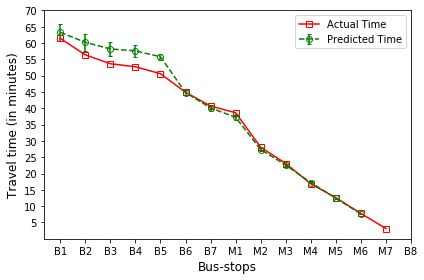

In [119]:
ArrivalTimePrediction(7) # for trip 22_12_2017__18_38_34